In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" #"last expr -> all로 바꾸면 전체가 나온다. "

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_finance import candlestick_ohlc
mpl.rc('font', family='NanumGothic') #폰트 한글 포함 가능 설정
mpl.rc('axes', unicode_minus=False) #유니코드에서 음수 부호 설정

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pickle 
from training_util_mae2 import (MyDataset, split, Transformer_park, Transformer_pretrain,
                        base_model, base_decoder, hierachy_model, train, validate, weighted_sampling,
                              eval_model)
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm 
import torch
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader
import easydict
import warnings
warnings.filterwarnings("ignore")

/home/ubuntu/anaconda3/envs/park/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 여기는 이전 whole_data로 들어가기 직전까지 데이터를 모두 feather화 시킴 
* 즉 마지막 cleansed data임

In [2]:
vital = pd.read_feather("final_vital0628.feather")
date = pd.read_feather("final_day0628.feather")
pt = pd.read_feather("final_base0628.feather")
outc = pd.read_feather("final_outcome0628.feather")

file_name = "../whole_3data0630_o2_idscale.txt"
file_name2 = "../whole_3data0630.txt"

* The vital file means data collected by 8-hour

In [8]:
vital.head()

,id,start_date,end_date,vs_record_date,time_hour,mean_BT,mean_DBP,mean_PR,mean_RR,mean_SBP,...,vent,mean_fio2,max_fio2,min_fio2,median_fio2,var_fio2,count_fio2,diff_mean_fio2,diff_max_fio2,diff_min_fio2
0,43967,2021-05-21,2021-06-04,2021-05-21,00_08,36.5,78.0,78.0,18.0,118.0,...,0.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0
1,43967,2021-05-21,2021-06-04,2021-05-21,08_16,36.5,78.0,78.0,18.0,118.0,...,0.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0
2,43967,2021-05-21,2021-06-04,2021-05-21,16_24,37.1,106.0,79.0,18.0,148.0,...,0.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0
3,43967,2021-05-21,2021-06-04,2021-05-22,00_08,37.0,95.0,66.0,18.0,159.0,...,0.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0
4,43967,2021-05-21,2021-06-04,2021-05-22,08_16,37.2,98.5,79.5,18.0,136.5,...,0.0,21.0,21.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0


* The date file means data collected by 24-hour

In [9]:
date.head()

,id,start_date,end_date,day,mean_lab_BUN,mean_lab_CK,mean_lab_CRP,mean_lab_Cr,mean_lab_Ferritin,mean_lab_GFR,...,rhinorrhea_flag,soreThroat_flag,sputum_flag,vomiting_flag,Regdanvimab,remdesivir,steroid_mean,steroid_max,steroid_min,id_encounter
0,43967,2021-05-21,2021-06-04,2021-05-21,10.4285,41.64,0.02,0.568428,42.275,96.82545,...,0.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,16.0,43967_5_21
1,43967,2021-05-21,2021-06-04,2021-05-22,10.0000,43.00,0.91,0.610000,42.275,90.55000,...,0.0,0.0,0.0,0.0,0.0,1.0,68.0,120.0,16.0,43967_5_21
2,43967,2021-05-21,2021-06-04,2021-05-23,10.0000,43.00,0.91,0.610000,42.275,90.55000,...,0.0,0.0,0.0,0.0,0.0,1.0,68.0,120.0,16.0,43967_5_21
3,43967,2021-05-21,2021-06-04,2021-05-24,26.0000,23.00,0.39,0.610000,617.000,94.60000,...,0.0,0.0,0.0,0.0,0.0,1.0,68.0,120.0,16.0,43967_5_21
4,43967,2021-05-21,2021-06-04,2021-05-25,26.0000,23.00,0.39,0.610000,617.000,94.60000,...,0.0,0.0,0.0,0.0,0.0,1.0,68.0,120.0,16.0,43967_5_21


* pt file means patient-level dataset

In [10]:
pt.head()

,id,start_date,end_date,nrRecord_age_cal_yr,nrRecord_sex_cat,nrRecord_case_yn,nrRecord_smoke_yn,nrRecord_smoke_PD,nrRecord_smoke_term_yr,nrRecord_smoke_PY,...,nrRecord_heartDs_yn,nrRecord_brainDs_yn,nrRecord_lungDs_yn,nrRecord_liverDs_yn,nrRecord_hollowViscusDs_yn,nrRecord_otherDx_yn_raw,nrRecord_ophx_yn_raw,nrRecord_admhx_yn_raw,id_encounter,length
0,43967,2021-05-21,2021-06-04,79.0,0,1,0,0.0,0.0,0.0,...,0,1,0,0,0,1,1,1,43967_5_21,14 days
1,58220,2021-08-14,2021-08-20,39.0,0,1,1,1.0,10.0,10.0,...,0,0,0,0,0,0,0,0,58220_8_14,6 days
2,124215,2020-06-22,2020-07-13,86.0,0,1,0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,1,124215_6_22,21 days
3,634060,2021-07-20,2021-07-28,26.0,1,1,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,634060_7_20,8 days
4,685845,2020-12-18,2020-12-25,58.0,1,1,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,685845_12_18,7 days


* get the column of each vital sign <br>
 column 0: body temperature <br>
 column 1: DBP <br>
 column 2: PR <br>
 column 3: RR <br>
 column 4: SBP <br>
 column 5: SpO2 <br>
 column 66: mean_FiO2 <br>

In [12]:
#target line`
list1 = ['mean_DBP','max_SBP','min_DBP', 'mean_SBP',]
list2 = ['mean_BT','mean_PR','mean_RR','mean_SpO2','mean_fio2']
def get_number(dataset, list1):
    col_index = []
    for i in list1:
        col_index.append(dataset.columns.get_loc(i))
    return col_index

vital_number = get_number(vital, list1)
etc_number = get_number(vital, list2)
print(vital_number)
print('mean_BT','mean_PR','mean_RR','mean_SpO2','mean_fio2',etc_number)

[6, 15, 18, 9]
mean_BT mean_PR mean_RR mean_SpO2 mean_fio2 [5, 7, 8, 10, 66]


### load trained model

* laboratory column were decided by same way and previously gathered in another jupyter lab

In [14]:
lab_number = [16, 17, 0, 3, 2, 27] 

In [15]:
# [6, 15, 18, 9] vital number 
def data_shape(lab_number, test_set, i):
    shape2 = test_set[i][2].shape[-1]
    mean_DBP = np.expand_dims(test_set[i][2].reshape(-1,shape2).T[1,:], axis=0)
    max_SBP = np.expand_dims(test_set[i][2].reshape(-1,shape2).T[10,:], axis=0)
    min_DBP = np.expand_dims(test_set[i][2].reshape(-1,shape2).T[13,:], axis=0)
    mean_SBP = np.expand_dims(test_set[i][2].reshape(-1,shape2).T[4,:], axis=0)
    
    pulse = test_set[i][2].reshape(-1,shape2).T[2,:]
    rr = test_set[i][2].reshape(-1,shape2).T[3,:]
    bt = test_set[i][2].reshape(-1,shape2).T[0,:]
    spo2 = test_set[i][2].reshape(-1,shape2).T[5,:]
    fio2 = test_set[i][2].reshape(-1,shape2).T[61,:]

    wbc = test_set[i][1].T[lab_number[0],:]
    alb = test_set[i][1].T[lab_number[1],:]
    bun = test_set[i][1].T[lab_number[2],:]
    cr = test_set[i][1].T[lab_number[3],:]
    crp = test_set[i][1].T[lab_number[4],:]
    procal = test_set[i][1].T[lab_number[5],:]
    
    bp_set = np.concatenate([mean_DBP, max_SBP, min_DBP, mean_SBP])
    bp_set = bp_set.T
    xlist = np.arange(len(bp_set))
    dohlc = np.hstack((np.reshape(xlist, (-1,1)),bp_set))
    
    target = test_set[i][3]
    
    return [xlist, dohlc, pulse, rr, bt, spo2, fio2, target,
            wbc, alb, bun, cr, crp, procal]


In [16]:
def loading_model(args, loaded_model):
    b_model = base_model(n_each_base = args.n_each_base,
                         mask_on=args.mask_on)
    vital_model = Transformer_park(n_each_lab = args.n_each_vital,
                                       n_embed = args.n_embed, 
                                       nhead = args.nhead, 
                                       nhid = args.nhid, 
                                       nlayers = args.nlayers, 
                                       dropout = args.dropout, 
                                       mask_on = args.mask_on)
    lab_model = Transformer_park(n_each_lab = args.n_each_lab,
                                     n_embed = args.n_embed, 
                                     nhead = args.nhead, 
                                     nhid = args.nhid, 
                                     nlayers = args.nlayers, 
                                     dropout = args.dropout, 
                                     mask_on = args.mask_on )
    decoder_vital = Transformer_pretrain(n_each_lab = args.n_each_vital,
                                        n_embed = args.n_embed)
    decoder_lab = Transformer_pretrain(n_each_lab = args.n_each_lab,
                                       n_embed = args.n_embed)
    decoder_base = base_decoder(n_each_base = args.n_each_base)
    total_model = hierachy_model(vital_shape = args.vital_shape, 
                                 lab_shape = args.lab_shape, 
                                 batch_size =args.test_batchsize, 
                                 output_len = args.output_len)

    vital_model.load_state_dict(loaded_model['vital_model_dict'])
    lab_model.load_state_dict(loaded_model['lab_model_dict'])
    b_model.load_state_dict(loaded_model['b_model_dict'])
    total_model.load_state_dict(loaded_model['total_model_dict'])
    decoder_vital.load_state_dict(loaded_model['decoder_vital_dict'])
    decoder_lab.load_state_dict(loaded_model['decoder_lab_dict'])
    decoder_base.load_state_dict(loaded_model['decoder_base_dict'])
    
    vital_model.eval()
    lab_model.eval()
    b_model.eval()
    total_model.eval()
    decoder_vital.eval()
    decoder_lab.eval()
    decoder_base.eval()

    return vital_model, lab_model, b_model, total_model, decoder_vital, decoder_lab, decoder_base

In [17]:
def predicted_outcome(test_loader, vital_model, lab_model, b_model, total_model, 
                decoder_vital, decoder_lab, decoder_base):
    for batch, batch_data in enumerate(test_loader):
        vital_set = batch_data[0]
        lab_set = batch_data[1]
        baseline_set = batch_data[2]
        each_att_vital_set = batch_data[3]
        each_att_lab_set = batch_data[4]
        each_att_base_set = batch_data[5]
        att_vital_set = batch_data[6]
        att_lab_set = batch_data[7]
        outcome = batch_data[8]
        outcome = outcome.type(torch.LongTensor)

        vital_tensor = vital_model(vital_set.transpose(0,1), att_vital_set,
                                   each_mask = each_att_vital_set.transpose(0,1))
        lab_tensor = lab_model(lab_set.transpose(0,1), att_lab_set,
                               each_mask = each_att_lab_set.transpose(0,1))
        base_tensor = b_model(baseline_set, each_att_base_set)

        vital_out = decoder_vital(vital_tensor)  #MLM용도
        lab_out = decoder_lab(lab_tensor)    #MLM 용도
        base_out = decoder_base(base_tensor) #MLM 용도

        #compute loss
        result = total_model(vital_tensor, lab_tensor, base_tensor)
        
        if batch==0:
            result_t = result.cpu().detach()
            outcome_t =outcome.cpu().detach()
        else:
            result_t = torch.cat([result.cpu(), result_t],axis=0).detach()
            outcome_t = torch.cat([outcome.cpu(), outcome_t],axis=0).detach()
            
    return result_t, outcome_t

In [18]:
def get_filepath(path):
    filename = [x for x in os.listdir(path) if "hos18" in x and "model2" in x]
    if len(filename)==1:
        filepath = path+filename[0]
    return filepath

In [19]:
args = easydict.EasyDict({"masking_value": 0,
                          "batch_size": 1000,
                          "file_name": "../whole_3data0630_o2_idscale.txt",
                          "min_epoch": 200,
                          "n_epochs_stop": 10,
                          "epochs": 1000,
                          "early_stop": True,
                          "nhead": 4,
                          "n_embed": 160,
                          "nhid": 320,
                          "nlayers": 4,
                          "dropout": 0.2,
                          "lr_": 5e-5,
                          "weight_decay_": 1e-4,
                          "output_len": 3,
                          "prior_d":0,
                          "weight": 1.0,
                          "mae": False,
                          "mask_on":True,
                          "masking_ratio": 0.,
                          "metric": 'total_loss',
                          "cuda_i" : 1, #cuda device number
                            "save_path" : "./save_confidence_interval"
                          })

* select the number which means random seed
* select the padded_hosday: which means the length of input shape <br>
 pre-trained model was saved as following names

In [21]:
number=2; padded_hosday = 18

train_set, valid_set, test_set = split(args.file_name, random_s=number) 
train_set2, valid_set2, test_set2 = split(file_name2, random_s=number) 

args.n_each_vital = train_set[0][2].shape[-1]
args.n_each_lab = train_set[0][1].shape[-1]
args.n_each_base = train_set[0][0].shape[-1]

args.vital_shape = padded_hosday*3*args.n_embed
args.lab_shape = padded_hosday*args.n_embed

filepath0 = get_filepath("./save_confidence_interval/")
filepath1 = get_filepath("./save_confidence_interval_day1/")
filepath2 = get_filepath("./save_confidence_interval_day2/")

In [26]:
print("pretrained for day0 prediction model:", filepath0)
print("pretrained for day1 prediction model:", filepath1)
print("pretrained for day2 prediction model:", filepath2)

pretrained for day0 prediction model: ./save_confidence_interval/model2_pad_hos18_emb_160_    hid_320_layer_4_lr_5e-05_mr0.0.pt
pretrained for day1 prediction model: ./save_confidence_interval_day1/model2_pad_hos18_emb_160_    hid_320_layer_4_lr_5e-05_mr0.0.pt
pretrained for day2 prediction model: ./save_confidence_interval_day2/model2_pad_hos18_emb_160_    hid_320_layer_4_lr_5e-05_mr0.0.pt


In [27]:
fig_folder = './test_set0822_3/'
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)

In [28]:
def model_and_predict(i):
    test_dataset = MyDataset(masking_value, test_set[i:1+i], padded_hosday, data_pr = 1, prior_d=0)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)

    batch_size = test_set[i:1+i][0][1].shape[0]
    args.test_batchsize = len(test_dataset)
    loaded_model_0 = torch.load(filepath0)
    load_0 = loading_model(args, loaded_model_0)
    loaded_model_1 = torch.load(filepath1)
    load_1 = loading_model(args, loaded_model_1)
    loaded_model_2 = torch.load(filepath2)
    load_2 = loading_model(args, loaded_model_2)

    predicted, outcome = predicted_outcome(test_loader, load_0[0], load_0[1],
                                   load_0[2],load_0[3], load_0[4], load_0[5], load_0[6])
    result0 = np.array(torch.argmax(nn.Softmax()(predicted), axis=1))
    predicted1, outcome1 = predicted_outcome(test_loader, load_1[0], load_1[1],
                                   load_1[2],load_1[3], load_1[4], load_1[5], load_1[6])
    result1 = np.array(torch.argmax(nn.Softmax()(predicted1), axis=1))
    predicted2, outcome2 = predicted_outcome(test_loader, load_2[0], load_2[1],
                                   load_2[2],load_2[3], load_2[4], load_2[5], load_2[6])
    result2 = np.array(torch.argmax(nn.Softmax()(predicted2), axis=1))
    each_data= data_shape(lab_number, test_set2, i)
    target_list = np.array(range(len(each_data[7])))

    each_data[1][:,0] = (each_data[1][:,0] -1)/3 #candle plot의 axis조정 
    each_data[0] =(each_data[0]-1)/3  #daily prediction에 맞게 조정
    
    return target_list, each_data, result0, result1, result2

### Exmaple print of Figure 
* select the patient ID

In [19]:
for i, test_ in enumerate(test_set):
    if test_[4] == '1767821_8_4':
        print(i)

553


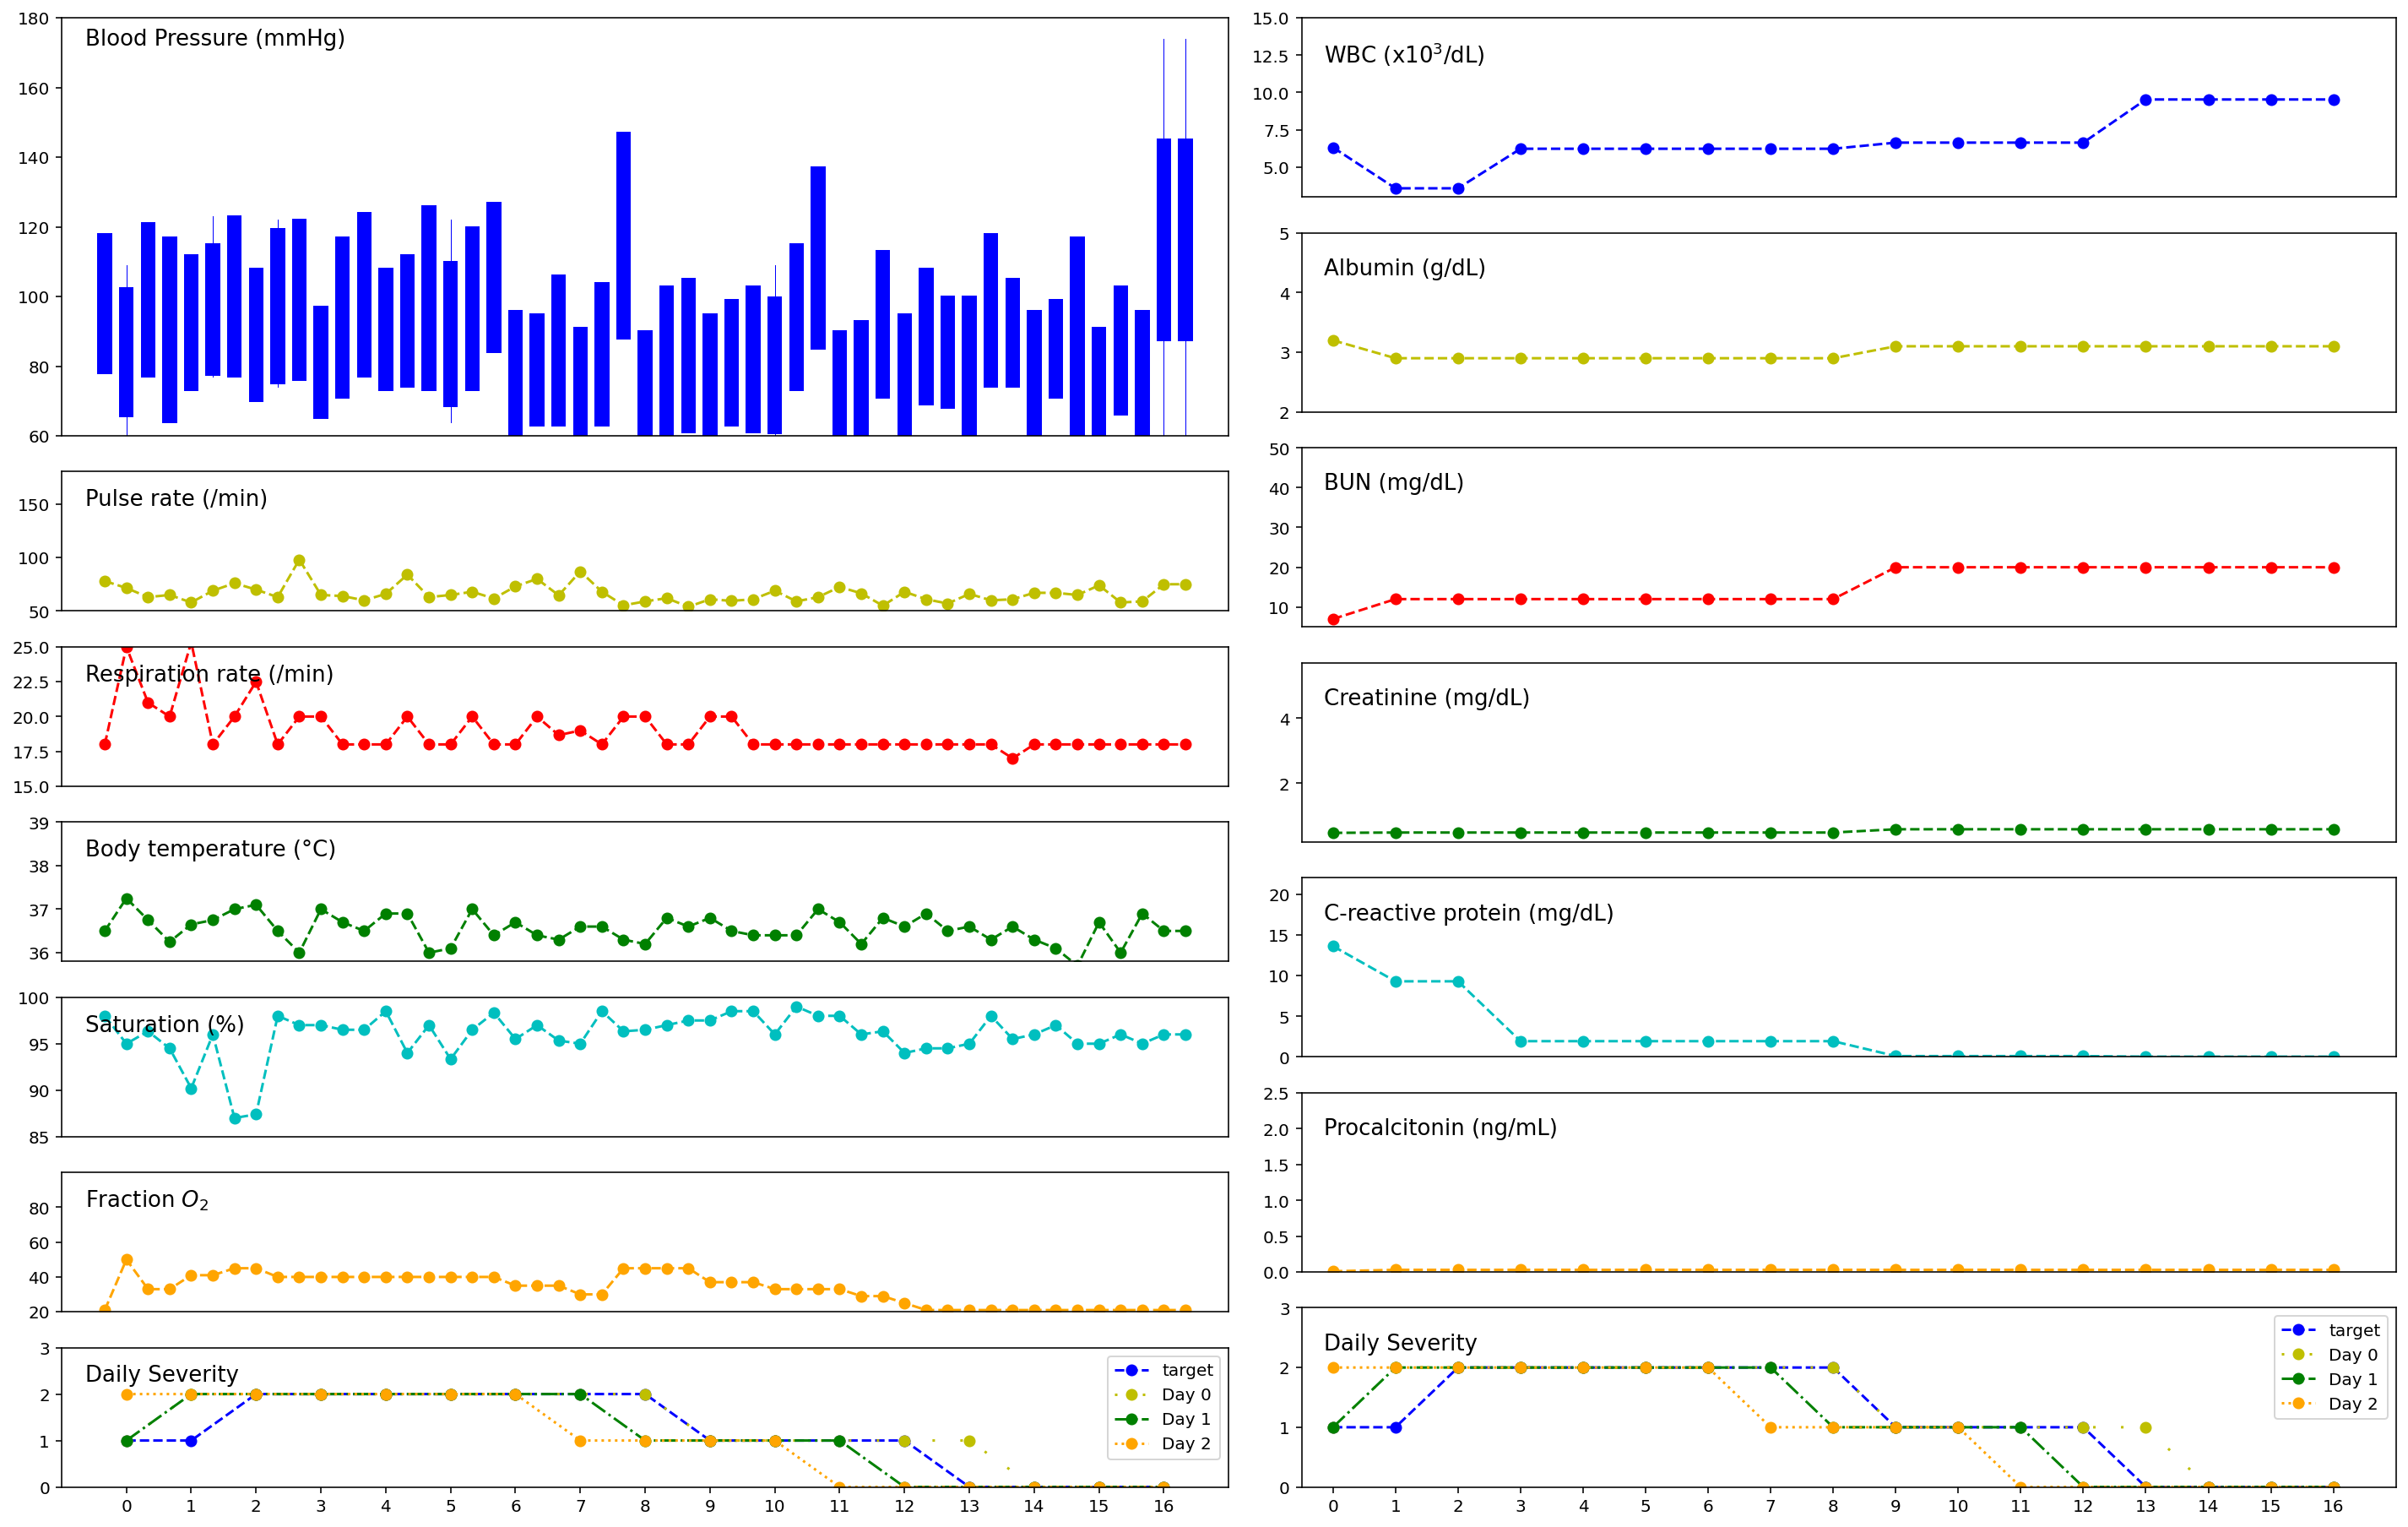

In [25]:
list_except = []
for i in [553]:
# for i in tqdm(range(0, 10,1)):
    try:
        target_list, each_data, result0, result1, result2 = model_and_predict(i)
        fig = plt.figure(figsize=(20,16), facecolor='white')

        # GridSpec 객체 생성
        gs1 = fig.add_gridspec(nrows=7, ncols=1, height_ratios = [3,1,1,1,1,1,1], left=0.02, right=0.5)
        gs2 = fig.add_gridspec(nrows=7, ncols=1, height_ratios = [1,1,1,1,1,1,1], left=0.53, right=0.98)
        axes = []
        axes2 = []
        for fig_i in range(7):
            if fig_i ==0:
                axes.append(fig.add_subplot(gs1[fig_i]))
                axes2.append(fig.add_subplot(gs2[fig_i]))
            else:
                axes.append(fig.add_subplot(gs1[fig_i], sharex=axes[0]))
                axes2.append(fig.add_subplot(gs2[fig_i], sharex=axes2[0]))

        anno_opts = dict(xy=(0.02, 0.8), xycoords='axes fraction', fontsize=13, 
                         va='center',
                         ha='left')
        #axis 1
        _ = axes[0].annotate("Blood Pressure (mmHg)", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=13, 
                         va='center', ha='left')
        _ = axes[0].get_xaxis().set_visible(False)
        _ = axes[1].annotate("Pulse rate (/min)", **anno_opts)
        _ = axes[1].get_xaxis().set_visible(False)
        _ = axes[2].annotate("Respiration rate (/min)", **anno_opts)
        _ = axes[2].get_xaxis().set_visible(False)
        _ = axes[3].annotate(u"Body temperature (\u00b0C)", **anno_opts)
        _ = axes[3].get_xaxis().set_visible(False)
        _ = axes[4].annotate("Saturation (%)", **anno_opts)
        _ = axes[4].get_xaxis().set_visible(False)
        _ = axes[5].annotate(r"Fraction $O_2$", **anno_opts)
        _ = axes[5].get_xaxis().set_visible(False)
        _ = axes[6].annotate("Daily Severity", xy=(0.02, 0.8), xycoords='axes fraction', fontsize=13, 
                         va='center', ha='left')
        _ = candlestick_ohlc(axes[0], each_data[1], width=0.2, colorup='b', colordown='b')

        _ = axes[1].plot(each_data[0], each_data[2], color='y', marker = 'o', linestyle = '--')
        _ = axes[2].plot(each_data[0], each_data[3], color='r', marker = 'o', linestyle = '--')
        _ = axes[3].plot(each_data[0], each_data[4], color='g', marker = 'o', linestyle = '--')
        _ = axes[4].plot(each_data[0], each_data[5], color='c', marker = 'o', linestyle = '--')
        _ = axes[5].plot(each_data[0], each_data[6], color='orange', marker = 'o', linestyle = '--')
        _ = axes[6].plot(target_list, each_data[7], color='blue', marker = 'o', linestyle = '--', label="target")
        _ = axes[6].plot(target_list, result0, color='y', marker = 'o', linestyle = (0,(1,10)), label="Day 0")
        _ = axes[6].plot(target_list, result1, color='g', marker = 'o', linestyle = 'dashdot', label="Day 1")
        _ = axes[6].plot(target_list, result2, color='orange', marker = 'o', linestyle = 'dotted', label="Day 2")
        _ = axes[6].legend(loc="upper right")

        _ = axes[0].set_ylim([60,180])
        _ = axes[1].set_ylim([50,180])
        _ = axes[2].set_ylim([15,25])
        _ = axes[3].set_ylim([35.8,39])
        _ = axes[4].set_ylim([85, 100])
        _ = axes[4].set_xlim([-1, len(target_list)])

        _ = axes[4].set_xticks(target_list)
        _ = axes[5].set_ylim([20,100])
        _ = axes[5].set_yticks(range(20,100,20))
        _ = axes[6].set_ylim([0,3])
        # _ = axes[0].set_title(test_set[i:1+i][0][4])

        #axis2
        _ = axes2[0].annotate(r"WBC (x$10^3$/dL)", **anno_opts)
        _ = axes2[0].get_xaxis().set_visible(False)
        _ = axes2[1].annotate("Albumin (g/dL)", **anno_opts)
        _ = axes2[1].get_xaxis().set_visible(False)
        _ = axes2[2].annotate("BUN (mg/dL)", **anno_opts)
        _ = axes2[2].get_xaxis().set_visible(False)
        _ = axes2[3].annotate("Creatinine (mg/dL)", **anno_opts)
        _ = axes2[3].get_xaxis().set_visible(False)
        _ = axes2[4].annotate("C-reactive protein (mg/dL)", **anno_opts)
        _ = axes2[4].get_xaxis().set_visible(False)
        _ = axes2[5].annotate("Procalcitonin (ng/mL)", **anno_opts)
        _ = axes2[5].get_xaxis().set_visible(False)
        _ = axes2[6].annotate("Daily Severity", xy=(0.02, 0.8), xycoords='axes fraction', fontsize=13, 
                         va='center', ha='left')

        _ = axes2[0].plot(target_list, each_data[8], color='b', marker = 'o', linestyle = '--')
        _ = axes2[1].plot(target_list, each_data[9], color='y', marker = 'o', linestyle = '--')
        _ = axes2[2].plot(target_list, each_data[10], color='r', marker = 'o', linestyle = '--')
        _ = axes2[3].plot(target_list, each_data[11], color='g', marker = 'o', linestyle = '--')
        _ = axes2[4].plot(target_list, each_data[12], color='c', marker = 'o', linestyle = '--')
        _ = axes2[5].plot(target_list, each_data[13], color='orange', marker = 'o', linestyle = '--')
        _ = axes2[6].plot(target_list, each_data[7], color='blue', marker = 'o', linestyle = '--', label="target")
        _ = axes2[6].plot(target_list, result0, color='y', marker = 'o', linestyle = (0,(1,10)), label="Day 0")
        _ = axes2[6].plot(target_list, result1, color='g', marker = 'o', linestyle = 'dashdot', label="Day 1")
        _ = axes2[6].plot(target_list, result2, color='orange', marker = 'o', linestyle = 'dotted', label="Day 2")
        _ = axes2[6].legend(loc="upper right")

        _ = axes2[0].set_ylim([3,15])
        _ = axes2[1].set_ylim([2,5])
        _ = axes2[2].set_ylim([5,50])
        _ = axes2[3].set_ylim([0.2,5.7])
        _ = axes2[4].set_ylim([0,22])
        _ = axes2[5].set_ylim([0,2.5])
        _ = axes2[5].set_xlim([-0.5, len(target_list)])

        _ = axes2[6].set_xticks(target_list)
        _ = axes2[6].set_ylim([0,3])
        
        fig.tight_layout()
        plt.savefig("Figure 1.png", dpi=300)
        plt.show()
        # plt.close()
    except RuntimeError:
        list_except.append(i)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])